In [172]:
import Pkg

#Pkg.add("Functors")
using Zygote
using Flux
using Flux: onehotbatch, onecold, crossentropy
using MLDatasets
#using CUDA
using Statistics
using Plots
using Images
using Colors
using ImageTransformations
using MLUtils
using Functors


In [173]:
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
];

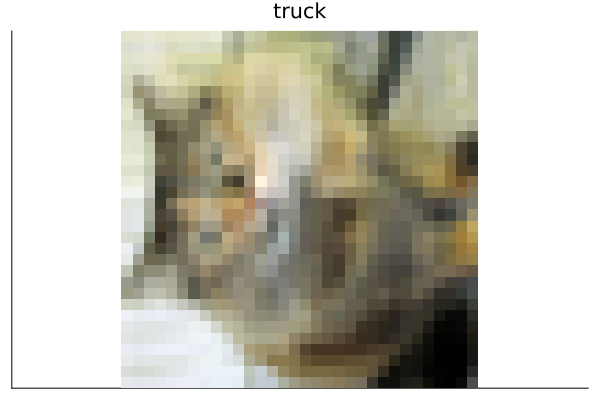

In [174]:
train_x_true, train_y_true = CIFAR10(:train)[:];

# Select the first image (H, W, C) = (32, 32, 3)
image_data = Float64.(train_x_true[:, :, :, 3])   # Normalize first

# Display image correctly (RGB expects (3, H, W))
plot(colorview(RGB, permutedims(image_flipped, (3, 1, 2))))
plot!(title=(class_names[train_y_true[3] + 1]))
plot!(xticks = false, yticks = false)

In [175]:
train_x, train_y = CIFAR10(:train).features, CIFAR10(:train).targets
test_x, test_y = CIFAR10(:test).features, CIFAR10(:test).targets

train_x = permutedims(Float32.(train_x) , (1,2,3,4))  
test_x = permutedims(Float32.(test_x) , (1,2,3,4)) 

train_y = onehotbatch(vec(train_y), 0:9)  
test_y = onehotbatch(vec(test_y), 0:9)

;

In [176]:
conv1 = Conv((3,3), 3=>16, relu, pad=1)
pool1 = MaxPool((2,2))
conv2 = Conv((3,3), 16=>32, relu, pad=1)
pool2 = MaxPool((2,2))
conv3 = Conv((3,3), 32=>64, relu, pad=1)
pool3 = MaxPool((2,2))
conv4 = Conv((3,3), 64=>128, relu, pad=1)
pool4 = MaxPool((2,2))
flatten = Flux.flatten
dense1 = Dense(512, 1024, relu)
dense2 = Dense(1024, 512)
dense3 = Dense(512, 10)

model = Chain(
    conv1,
    pool1,
    BatchNorm(16),
    conv2,
    pool2,
    BatchNorm(32),
    conv3,
    pool3,
    BatchNorm(64),
    conv4,
    pool4,
    BatchNorm(128),
    flatten,
    dense1,
    dense2,
    dense3,
    softmax
)

loss(m, x, y) = crossentropy(m(x), y)

opt = ADAM();

In [177]:
function train_model!(model, train_X, train_Y, opt, epochs, batch_size)
    data_loader = Flux.DataLoader((train_X, train_Y), batchsize=batch_size, shuffle=true)
    
    opt_state = Flux.setup(opt, model)  
    total_loss = []

    for epoch in 1:epochs
        epoch_loss = 0
        for (x, y) in data_loader
            gs = Flux.gradient(model -> Flux.Losses.crossentropy(model(x), y), model)[1]  
            Flux.update!(opt_state, Flux.trainable(model), gs)
            epoch_loss += Flux.Losses.crossentropy(model(x), y)
        end
        println("Epoch $epoch complete")
        push!(total_loss, epoch_loss)
    end
    return total_loss
end;

In [178]:
epochs = 2
batch_size = 64;

In [179]:
loss_list = train_model!(model, train_x, train_y, opt, epochs, batch_size);

Epoch 1 complete
Epoch 2 complete


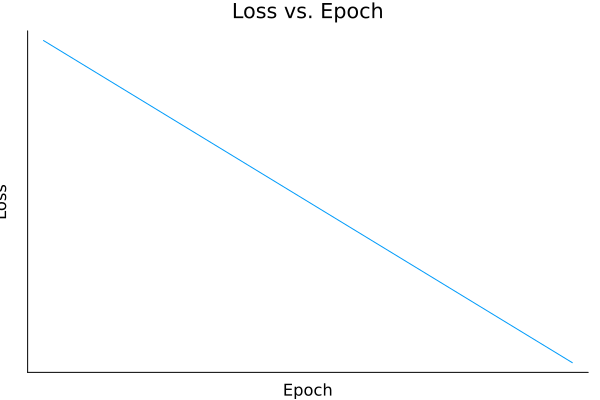

In [180]:
p1 = plot(1:epochs, loss_list, xlabel="Epoch", ylabel="Loss", title="Loss vs. Epoch", legend=false, xticks=false, yticks=false)
display(p1)

In [181]:
#visualize_layers(model, train_x[:, :, :, 1:1])

accuracy(x, y) = mean(onecold(model(x)) .== onecold(y))
println("Test Accuracy: ", accuracy(test_x, test_y))


Test Accuracy: 0.6576


In [182]:
function visualize_layer(input_data, layer, filter_labels)
    output = layer(input_data)  # Apply the convolutional layer

    num_filters = size(output, 4)  # Number of output channels

    # Create input plot
    input_plot = heatmap(input_data[:, :, 1, 1], axis=nothing, title=label, xticks=false, yticks=false, colorbar=false,
    #color =:acton, 
    aspect_ratio=:equal
    )

    # Create output plots for each filter response with labels
    output_plots = [
        heatmap(output[:, :, 1, i], axis=nothing, 
                title=filter_labels,
                xticks=false, yticks=false, colorbar=false,
                #color =:acton
                ) 
        for i in 1:num_filters
    ]

    # Arrange plots in a grid (side by side)
    plot(input_plot, output_plots..., layout=(1, num_filters + 1))
end

using Flux

# Define each filter as a 3x3 matrix

# Laplacian
f1 = [ 0  -1  0; -1  4 -1;  0  -1  0 ]

# Sharpening
f2 = [ 0  -1  0; -1  9 -1;  0  -1  0 ]

# Sobels
f3 = [ 1   2  1;  0  0  0; -1  -2 -1 ]
f4 = [ 1   0 -1;  2  0 -2;  1   0 -1 ]

# Gaussian Blur
f5 = (1/16).*[ 1   2  1;  2  4  2;  1   2  1 ]
f7 = (1/273).*[ 1 4 7 4 1; 4 16 26 16 4; 7 26 41 26 7; 4 16 26 16 4; 1 4 7 4 1 ] 
f8 = (1/1003) .* [ 0 0 1 2 1 0 0; 0 3 13 22 13 3 0; 1 13 59 97 59 13 1; 2 22 97 159 97 22 2; 1 13 59 97 59 13 1; 0 3 13 22 13 3 0; 0 0 1 2 1 0 0 ]

# Embossing
f6 = [-2  -1  0; -1  1  1;  0   1  2 ]

# Box Blur
f9 = (1/9) .* [ 1 1 1; 1 1 1; 1 1 1 ]


f10 = (-1/256).*[ 1 4 6 4 1; 4 16 24 16 4; 6 24 -476 24 6; 4 16 24 16 4; 1 4 6 4 1 ]

# some custom filter
f11 = [ 4 0 1 0 1; 0 0 0 0 0; 1 0 10 0 1; 0 0 0 0 0; 1 0 1 0 1]

# Inverse Gaussian Blur
f12 = (1/14).*[ 20 5 20; 5 0 5; 20 5 20]

# Alternative Sobels
f13 = [ 3 0 -3; 10 0 -10; 3 0 -3]
f14 = [ 3 10 3; 0 0 0; -3 -10 -3]

# Scharr Operator
f15 = [47 0 -47; 162 0 -162; 47 0 -47]
f17 = [47 162 47; 0 0 0; -47 -162 -47]

# Reshape each filter to include the input channel and output channel dimensions (3, 3, 1, 1)
f1_tensor = reshape(f1, (3, 3, 1, 1))
f2_tensor = reshape(f2, (3, 3, 1, 1))
f3_tensor = reshape(f3, (3, 3, 1, 1))
f4_tensor = reshape(f4, (3, 3, 1, 1))
f5_tensor = reshape(f5, (3, 3, 1, 1))
f6_tensor = reshape(f6, (3, 3, 1, 1))
f7_tensor = reshape(f7, (5, 5, 1, 1))
f8_tensor = reshape(f8, (7, 7, 1, 1))
f9_tensor = reshape(f9, (3, 3, 1, 1))
f10_tensor = reshape(f10, (5, 5, 1, 1))
f11_tensor = reshape(f11, (5, 5, 1, 1))
f12_tensor = reshape(f12, (3, 3, 1, 1))
f13_tensor = reshape(f13, (3, 3, 1, 1))
f14_tensor = reshape(f14, (3, 3, 1, 1))
f15_tensor = reshape(f15, (3, 3, 1, 1))
f17_tensor = reshape(f17, (3, 3, 1, 1))



# Define filter labels corresponding to their function
filter_labels = [
    "Laplacian (Edge Detection)", 
    "Sharpening", 
    "Sobel (Vertical Edges)", 
    "Sobel (Horizontal Edges)", 
    "Gaussian Blur",
    "Embossing",
    "Large Gaussian Blur",
    "Super Large Gaussian Blur",
    "Box Blur",
    "Unsharp Masking",
    "Every Other",
    "Inverse Gaussian Blur",
    "Alternative Sobel (Vertical Edges)",
    "Alternative Sobel (Horizontal Edges)",
    "Scharr Operator (Vertical Edges)",
    "Empty",
    "Scharr Operator (Horizontal Edges)"
];

n = length(filter_labels)

;

In [183]:
pad_set = 0
stride_set = 1
choice = 170
;

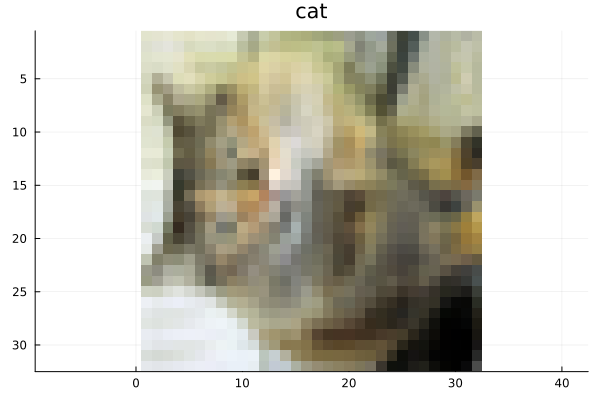

In [184]:
input_data = train_x[:, :, :, choice:choice];

image_data = Float64.(train_x_true[:, :, :, choice])   # Normalize first

image_flipped = reverse(image_data, dims=1)

plot(colorview(RGB, permutedims(image_flipped, (3, 1, 2))))
image_label = class_names[train_y_true[choice] + 1]
plot!(title=image_label)

In [185]:
conv_layer_1 = Conv((3, 3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_1.weight .=f1_tensor

conv_layer_2 = Conv((3, 3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_2.weight .=f2_tensor

conv_layer_3 = Conv((3, 3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_3.weight .=f3_tensor

conv_layer_4 = Conv((3, 3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_4.weight .=f4_tensor

conv_layer_5 = Conv((3, 3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_5.weight .=f5_tensor

conv_layer_6 = Conv((3, 3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_6.weight .=f6_tensor;

conv_layer_7 = Conv((5,5), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_7.weight .=f7_tensor;

conv_layer_8 = Conv((7,7), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_8.weight .=f8_tensor;

conv_layer_9 = Conv((3,3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_9.weight .=f9_tensor;

conv_layer_10 = Conv((5,5), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_10.weight .=f10_tensor;

conv_layer_11 = Conv((5,5), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_11.weight .=f11_tensor;

conv_layer_12 = Conv((3,3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_12.weight .=f12_tensor;

conv_layer_13 = Conv((3,3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_13.weight .=f13_tensor;

conv_layer_14 = Conv((3,3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_14.weight .=f14_tensor;

conv_layer_15 = Conv((3,3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_15.weight .=f15_tensor;

conv_layer_17 = Conv((3,3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_17.weight .=f17_tensor;



;

In [186]:
function visualize_layer(input_data, layer, filter_labels)
    output = layer(input_data)  # Apply the convolutional layer

    num_filters = size(output, 4)  # Number of output channels

    # Create input plot
    input_plot = heatmap(input_data[:, :, 1, 1], axis=nothing, title=image_label, xticks=false, yticks=false, colorbar=false,
    color =:acton, 
    aspect_ratio=:equal
    )

    # Create output plots for each filter response with labels
    output_plots = [
        heatmap(output[:, :, 1, i], axis=nothing, 
                title=filter_labels,
                xticks=false, yticks=false, colorbar=false,
                color =:acton
                ) 
        for i in 1:num_filters
    ]

    # Arrange plots in a grid (side by side)
    plot(input_plot, output_plots..., layout=(1, num_filters + 1))
end

using Flux

# Define each filter as a 3x3 matrix

# Laplacian
f1 = [ 0  -1  0; -1  4 -1;  0  -1  0 ]

# Sharpening
f2 = [ 0  -1  0; -1  9 -1;  0  -1  0 ]

# Sobels
f3 = [ 1   2  1;  0  0  0; -1  -2 -1 ]
f4 = [ 1   0 -1;  2  0 -2;  1   0 -1 ]

# Gaussian Blur
f5 = (1/16).*[ 1   2  1;  2  4  2;  1   2  1 ]
f7 = (1/273).*[ 1 4 7 4 1; 4 16 26 16 4; 7 26 41 26 7; 4 16 26 16 4; 1 4 7 4 1 ] 
f8 = (1/1003) .* [ 0 0 1 2 1 0 0; 0 3 13 22 13 3 0; 1 13 59 97 59 13 1; 2 22 97 159 97 22 2; 1 13 59 97 59 13 1; 0 3 13 22 13 3 0; 0 0 1 2 1 0 0 ]

# Embossing
f6 = [-2  -1  0; -1  1  1;  0   1  2 ]

# Box Blur
f9 = (1/9) .* [ 1 1 1; 1 1 1; 1 1 1 ]


f10 = (-1/256).*[ 1 4 6 4 1; 4 16 24 16 4; 6 24 -476 24 6; 4 16 24 16 4; 1 4 6 4 1 ]

# some custom filter
f11 = [ 4 0 1 0 1; 0 0 0 0 0; 1 0 10 0 1; 0 0 0 0 0; 1 0 1 0 1]

# Inverse Gaussian Blur
f12 = (1/14).*[ 20 5 20; 5 0 5; 20 5 20]

# Alternative Sobels
f13 = [ 3 0 -3; 10 0 -10; 3 0 -3]
f14 = [ 3 10 3; 0 0 0; -3 -10 -3]

# Scharr Operator
f15 = [47 0 -47; 162 0 -162; 47 0 -47]
f17 = [47 162 47; 0 0 0; -47 -162 -47]

# Reshape each filter to include the input channel and output channel dimensions (3, 3, 1, 1)
f1_tensor = reshape(f1, (3, 3, 1, 1))
f2_tensor = reshape(f2, (3, 3, 1, 1))
f3_tensor = reshape(f3, (3, 3, 1, 1))
f4_tensor = reshape(f4, (3, 3, 1, 1))
f5_tensor = reshape(f5, (3, 3, 1, 1))
f6_tensor = reshape(f6, (3, 3, 1, 1))
f7_tensor = reshape(f7, (5, 5, 1, 1))
f8_tensor = reshape(f8, (7, 7, 1, 1))
f9_tensor = reshape(f9, (3, 3, 1, 1))
f10_tensor = reshape(f10, (5, 5, 1, 1))
f11_tensor = reshape(f11, (5, 5, 1, 1))
f12_tensor = reshape(f12, (3, 3, 1, 1))
f13_tensor = reshape(f13, (3, 3, 1, 1))
f14_tensor = reshape(f14, (3, 3, 1, 1))
f15_tensor = reshape(f15, (3, 3, 1, 1))
f17_tensor = reshape(f17, (3, 3, 1, 1))



# Define filter labels corresponding to their function
filter_labels = [
    "Laplacian (Edge Detection)", 
    "Sharpening", 
    "Sobel (Vertical Edges)", 
    "Sobel (Horizontal Edges)", 
    "Gaussian Blur",
    "Embossing",
    "Large Gaussian Blur",
    "Super Large Gaussian Blur",
    "Box Blur",
    "Unsharp Masking",
    "Every Other",
    "Inverse Gaussian Blur",
    "Alternative Sobel (Vertical Edges)",
    "Alternative Sobel (Horizontal Edges)",
    "Scharr Operator (Vertical Edges)",
    "Empty",
    "Scharr Operator (Horizontal Edges)"
];

n = length(filter_labels)

;

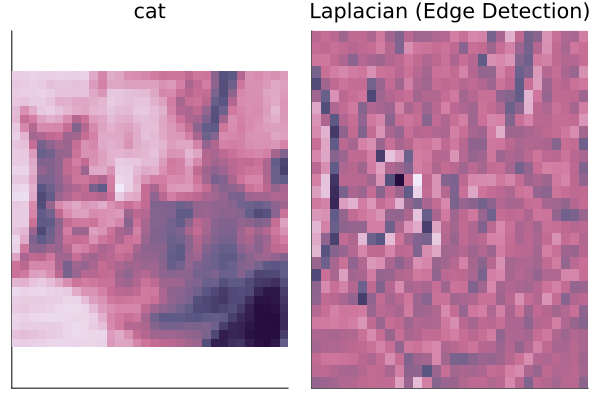

In [187]:
visualize_layer(input_data, conv_layer_1, filter_labels[1])

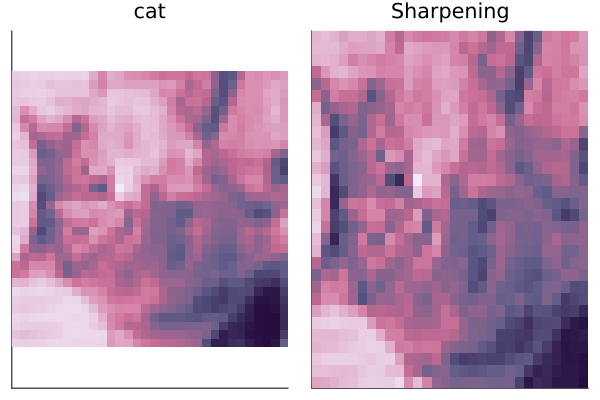

In [188]:
visualize_layer(input_data, conv_layer_2, filter_labels[2])

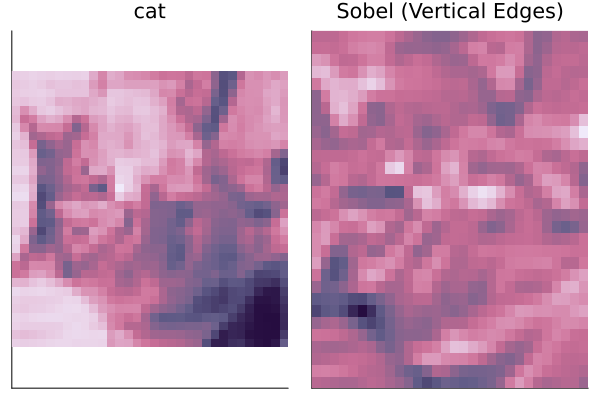

In [189]:
visualize_layer(input_data, conv_layer_3, filter_labels[3])

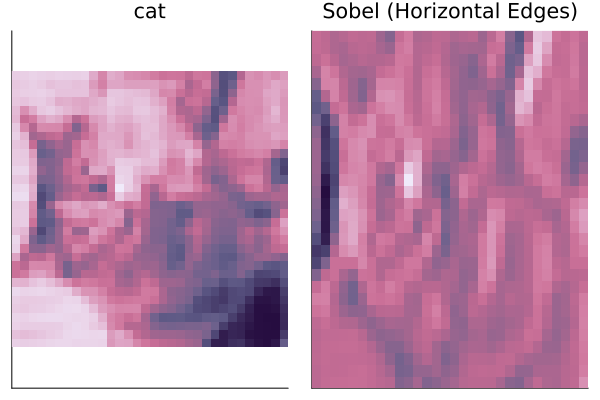

In [190]:
visualize_layer(input_data, conv_layer_4, filter_labels[4])

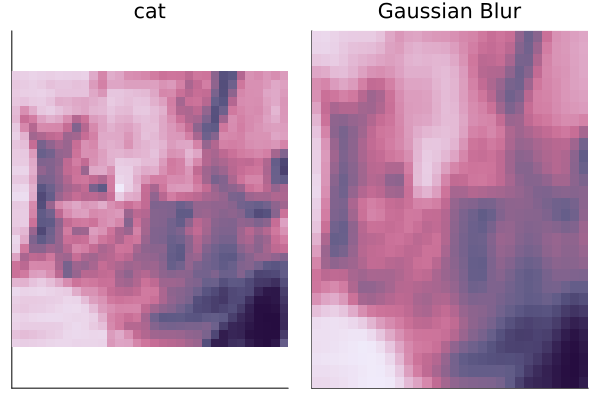

In [191]:
visualize_layer(input_data, conv_layer_5, filter_labels[5])

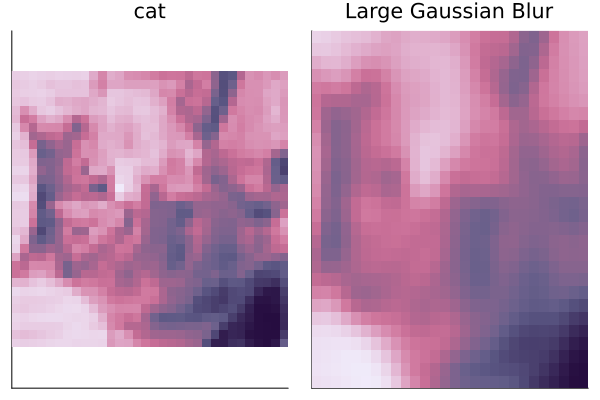

In [192]:
visualize_layer(input_data, conv_layer_7, filter_labels[7])

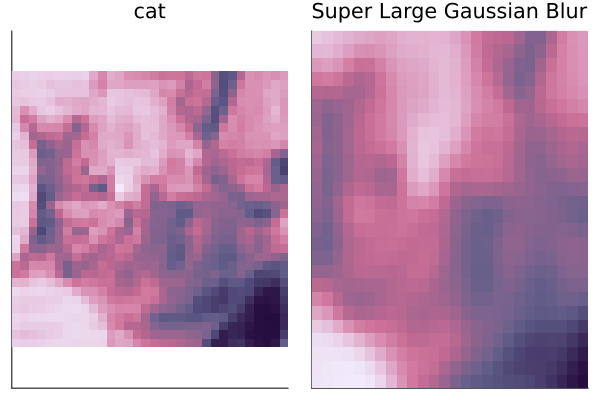

In [193]:
visualize_layer(input_data, conv_layer_8, filter_labels[8])

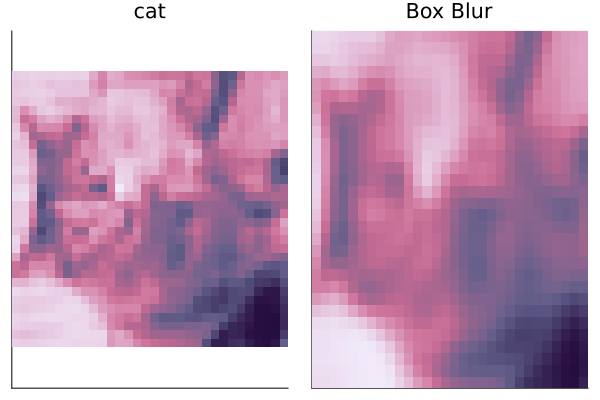

In [194]:
visualize_layer(input_data, conv_layer_9, filter_labels[9])

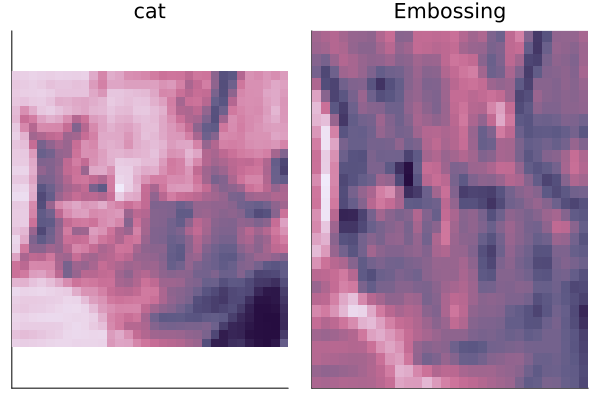

In [195]:
visualize_layer(input_data, conv_layer_6, filter_labels[6])

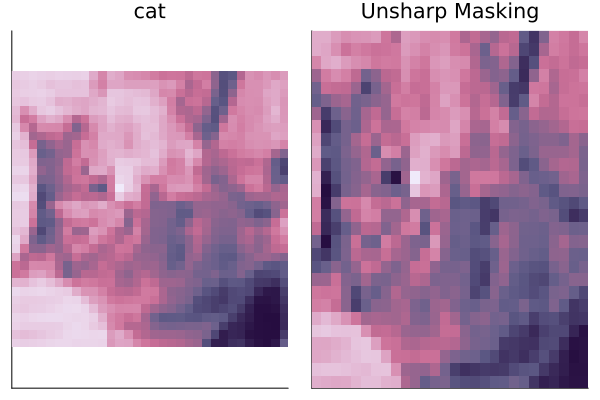

In [196]:
visualize_layer(input_data, conv_layer_10, filter_labels[10])

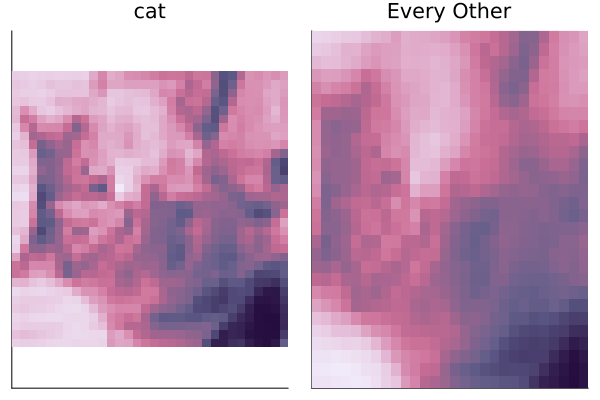

In [197]:
visualize_layer(input_data, conv_layer_11, filter_labels[11])

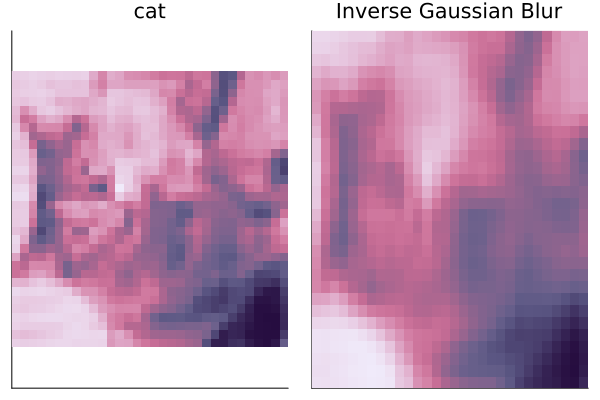

In [198]:
visualize_layer(input_data, conv_layer_12, filter_labels[12])

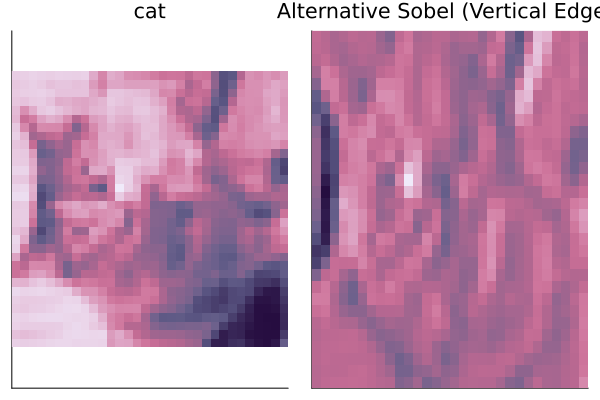

In [199]:
visualize_layer(input_data, conv_layer_13, filter_labels[13])

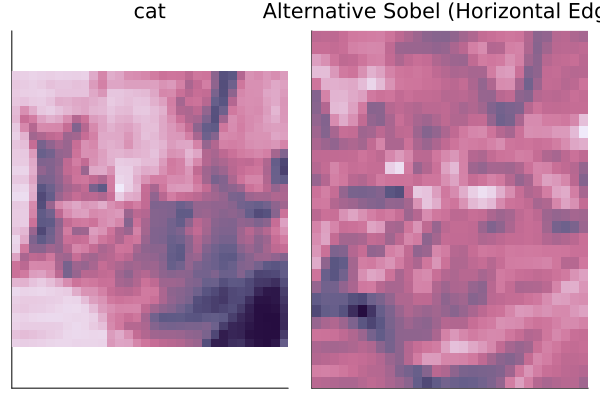

In [200]:
visualize_layer(input_data, conv_layer_14, filter_labels[14])

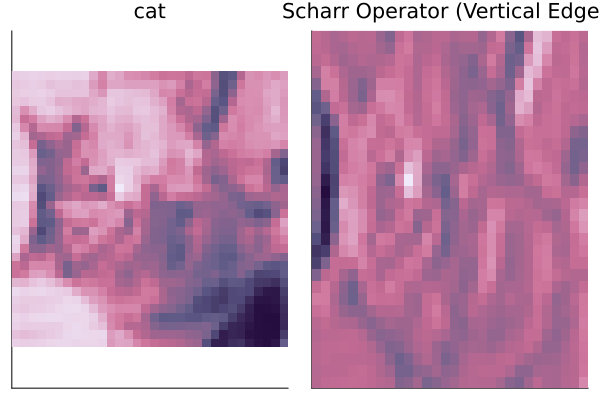

In [201]:
visualize_layer(input_data, conv_layer_15, filter_labels[15])

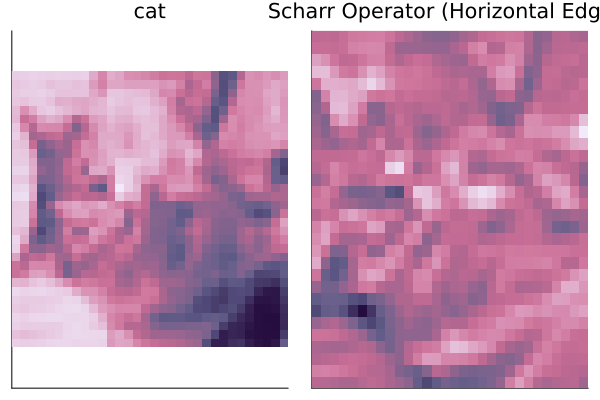

In [202]:
visualize_layer(input_data, conv_layer_17, filter_labels[17])

In [203]:
encoder = Chain(
    Conv((3,3), 3=>16, relu, pad=1),
    MaxPool((2,2)),
    Conv((3,3), 16=>32, relu, pad=1),
    MaxPool((2,2)),
    Conv((3,3), 32=>64, relu, pad=1),
    MaxPool((2,2)),
    Conv((3,3), 64=>128, relu, pad=1),
    MaxPool((2,2)),
    Flux.flatten
)

bottleneck = Chain(
    Dense(512, 2048, relu),
    Dense(2048, 8192, relu),
    x -> reshape(x, (4, 4, 512, size(x, 2)))  # Reshape to 4D tensor

)

decoder = Chain(
    #x -> reshape(x, (2, 2, 128, size(x, 2))),  
    ConvTranspose((3, 3), 512=>256, relu, pad=1),
    Upsample((2, 2)),
    ConvTranspose((3, 3), 256=>128, relu, pad=1),
    Upsample((2, 2)),
    ConvTranspose((3, 3), 128=>64, relu, pad=1),
    Upsample((2, 2)),
    ConvTranspose((3, 3), 64=>32, relu, pad=1),
    #Upsample((2, 2)),
    ConvTranspose((3, 3), 32=>3, σ, pad=1)  
)

# Combine everything into an autoencoder model
deconvolutional = Chain(encoder, bottleneck, decoder);


In [204]:
function train_deconvolutional!(model, train_loader, opt, epochs)
    opt_state = Flux.setup(opt, model)
    total_loss = []
    for epoch in 1:epochs
        epoch_loss = 0.0
        for data in train_loader
            x = data  # Assuming train_loader provides the input data
            gs, loss = Flux.withgradient(model -> Flux.Losses.mse(model(x), x), model)
            Flux.update!(opt_state, Flux.trainable(model), gs)
            epoch_loss += loss
        end
        epoch_loss /= length(train_loader)
        println("Epoch $epoch - Loss: $epoch_loss")
        push!(total_loss, epoch_loss)
    end
    return total_loss
end

;

In [205]:
train_loader = Flux.DataLoader(train_x, batchsize=64, shuffle=true)

loss_dc = train_deconvolutional!(deconvolutional, train_loader, opt_dc, epochs)

LoadError: type Float32 has no field layers

In [ ]:
test_img = train_x[:, :, :, choice]  
test_img_batch = reshape(test_img, (size(test_img)..., 1))  

reconstructed_img = deconvolutional(test_img_batch)
reconstructed_img = dropdims(reconstructed_img, dims=4)  

function show_image(img, title_str)
    plot(colorview(RGB, permutedims(img, (3,1,2))))
    title!(title_str)
    xticks!(false)
    yticks!(false)
end

# Display original and reconstructed images side by side
plot(layout=(1,2), size=(1600,800))
show_image(test_img, "Original Image")
show_image(reconstructed_img, "Reconstructed Image")